<a href="https://colab.research.google.com/github/semishen/ML100Days/blob/master/Day_023_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業 : (Kaggle)鐵達尼生存預測 
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察降低偏態的影響

# [作業重點]
- 觀察使用log1p降偏態時, 對於分布與迴歸分數的影響 (In[6], Out[6])
- 修正區塊中的資料問題後, 觀察以box-cox降偏態, 對於分布與迴歸分數的影響 (In[7], Out[7])

In [2]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
print('df_train.shape: ', df_train.shape)
print('df_test.shape: ', df_test.shape)
df.head()

df_train.shape:  (891, 10)
df_test.shape:  (418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
df_backup = df.copy() 

In [0]:
df = df_backup.copy()

In [4]:
df.dtypes.value_counts()

object     5
int64      3
float64    2
dtype: int64

In [12]:
k = df.loc[:, (df.dtypes == 'int64') |(df.dtypes == 'float64') ]

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500
...,...,...,...,...,...
413,3,NaN,0,0,8.0500
414,1,39.0,0,0,108.9000
415,3,38.5,0,0,7.2500
416,3,NaN,0,0,8.0500


In [13]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(0)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


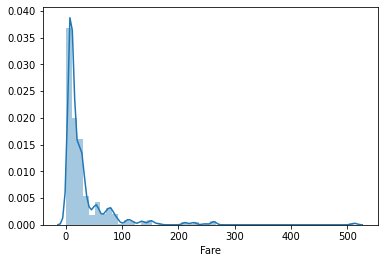

In [14]:
# 顯示 Fare 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(df['Fare'][:train_num])
plt.show()
plt.close()


In [15]:
# 計算基礎分數
df_mm = MMEncoder.fit_transform(df)
train_X = df_mm[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7015378821166279

# 作業1 
* 試著在鐵達尼的票價 (Fare) 欄位中使用對數去偏 (log1p) , 結果是否更好?

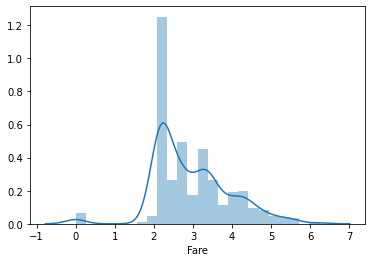

0.710545477371163

In [21]:
# 將 Fare 取 log1p 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)
df_fixed['Fare'] =np.log1p(df_fixed['Fare'])
sns.distplot(df_fixed['Fare'][:train_num])
plt.show()
plt.close()

df_fixed = MMEncoder.fit_transform(df_fixed) # return np array
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

In [20]:
df_fixed['Fare'].value_counts()

2.202765    60
2.639057    59
2.169054    55
3.295837    50
2.185579    49
            ..
2.214661     1
2.708050     1
2.148851     1
2.244246     1
3.306275     1
Name: Fare, Length: 281, dtype: int64

# 作業2
* 最後的 boxcox 區塊直接執行會造成錯誤, 起因為輸入值有負值, 請問如何修正後可以使用 boxcox? (Hint : 試圖修正資料)

before:
0.0000      18
3.1708       1
4.0125       1
5.0000       1
6.2375       1
            ..
227.5250     5
247.5208     3
262.3750     7
263.0000     6
512.3292     4
Name: Fare, Length: 281, dtype: int64
after:
1.0000      18
3.1708       1
4.0125       1
5.0000       1
6.2375       1
            ..
227.5250     5
247.5208     3
262.3750     7
263.0000     6
512.3292     4
Name: Fare, Length: 281, dtype: int64


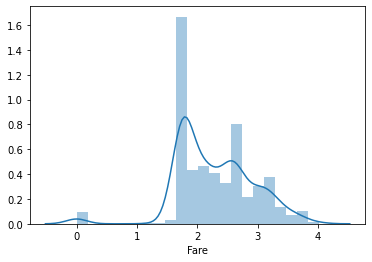

0.7094218818655451

In [35]:
#將 Fare 取 boxcox 後, 看散佈圖, 並計算分數 (執行會有 error, 請試圖修正)
from scipy import stats
df_fixed = copy.deepcopy(df)
print('before:')
print(df_fixed['Fare'].value_counts().sort_index())
df_fixed['Fare'].replace(0, 1, inplace = True)
print('after:')
print(df_fixed['Fare'].value_counts().sort_index())

df_fixed['Fare'] = stats.boxcox(df_fixed['Fare'])[0]
sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()